In [1]:
#import the standard libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

#import model learning libraries
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

#import advanced hyperparameters selection libraries
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna
from optuna import Trial, study, samplers

In [2]:
#import the data set
data = pd.read_csv('data/train_sem09.csv')

In [3]:
#read the data set
data.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


#### Описательный Анализ Данных

In [4]:
#find the basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [5]:
print(f'Размер таблицы: {data.shape}')

Размер таблицы: (3751, 1777)


In [6]:
#check that there are no null values in the data set
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

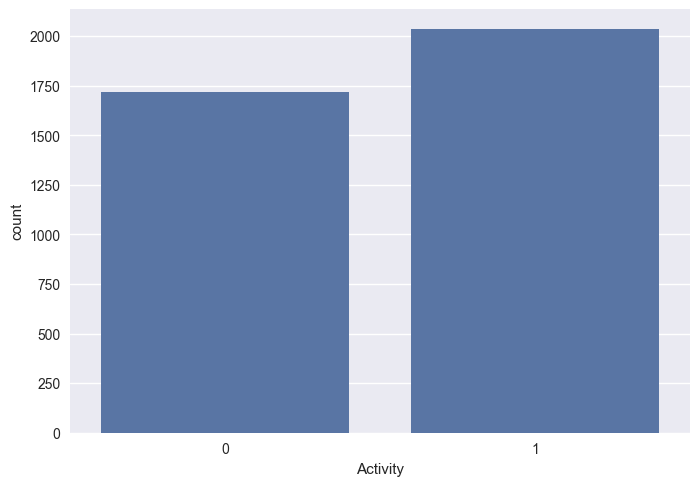

In [7]:
#check the predictive feature (%-wise)
round(data['Activity'].value_counts(normalize=True) * 100, 2)
sns.countplot(data=data,
              x='Activity');

### Обучение Модели

In [8]:
#select the features
X = data.drop(['Activity'],
              axis=1,
              errors='ignore')

y = data['Activity']

In [9]:
#split the data set into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.2
)

#### **Logistic Regression**

create a baseline logistic regression model

In [10]:
#create the object class
log_reg = linear_model.LogisticRegression(
    #to avoid a warning: no. of iterations reached the limit, default 100 increased to 200
    max_iter=200,
    random_state=42
)

#select the metrics
types_of_metrics = ['f1',
                    'accuracy',
                    'recall',
                    'precision']

#execute cross validation
cv_metrics = model_selection.cross_validate(
    estimator=log_reg,
    X=X_train,
    y=y_train,
    cv=5,
    scoring=types_of_metrics,
    #calculate metrics on train folds
    return_train_score=True,
    n_jobs=-1
)

#model learning
log_reg.fit(X_train, y_train)

#make a prediction
y_pred_estimator_tr = log_reg.predict(X_train)
y_pred_estimator_t = log_reg.predict(X_test)

#display the metrics
print('train data:')
print(f"f1 score: {np.mean(cv_metrics['train_f1']):.3f}")
print(f"accuracy: {np.mean(cv_metrics['train_accuracy']):.3f}")
print()
print('validation data:')
print(f"f1 score: {np.mean(cv_metrics['test_f1']):.3f}")
print(f"accuracy: {np.mean(cv_metrics['test_accuracy']):.3f}")
print()
print('test data:')
print(f'f1 score: {metrics.f1_score(y_test, y_pred_estimator_t):.3f}')
print(f'accuracy: {log_reg.score(X_test, y_test):.3f}')

train data:
f1 score: 0.905
accuracy: 0.896

validation data:
f1 score: 0.775
accuracy: 0.751

test data:
f1 score: 0.776
accuracy: 0.752


#### GridSearchCV

set the optimization problem pairs

| Solver          | Penalty                        | Multinomial Multiclass     |
| :-------------: | :----------------------------: | :------------------------: |
| lbfgs           | ‘l2’, None                     | yes                        |
| liblinear       | ‘l1’, ‘l2’                     | no                         |
| newton-cg       | ‘l2’, None                     | yes                        |
| newton-cholesky | ‘l2’, None                     | no                         |
| sag             | ‘l2’, None                     | yes                        |
| saga            | ‘elasticnet’, ‘l1’, ‘l2’, None | yes                        |

use the GridSearch method to look for best hyperparameters

- excluding elasticnet (with l1_ratio) and saga (with penalty=None): too many warnings / errors, and takes almost an hour to run crashing my system

In [11]:
#set the list of coefficient levels
coef_lst = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

#set the search grid for regression hyperparameters
param_grid = [
              {'penalty': ['l2', None],
               'solver': ['lbfgs', 'sag'], #optimization
               'C': coef_lst, # coefficient
              },
              
              {'penalty': ['l1', 'l2'], #regularization
               'solver': ['liblinear', 'saga'], #optimization
               'C': coef_lst, #coefficient
               }
]

In [12]:
#use the grid search to look for hyperparameters
grid_search = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(
        max_iter=2000,
        random_state=42),
    param_grid=param_grid, #search grid
    cv=5, #no of folds
    verbose=10, #logging output
    n_jobs=-1 #cores used, all
) 

#find the processing time
%time grid_search.fit(X_train, y_train)

#make a prediction
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 3/5; 1/64] START C=0.01, penalty=l2, solver=lbfgs...........................
[CV 4/5; 1/64] START C=0.01, penalty=l2, solver=lbfgs...........................
[CV 5/5; 1/64] START C=0.01, penalty=l2, solver=lbfgs...........................
[CV 1/5; 2/64] START C=0.01, penalty=l2, solver=sag.............................
[CV 2/5; 2/64] START C=0.01, penalty=l2, solver=sag.............................
[CV 3/5; 1/64] END C=0.01, penalty=l2, solver=lbfgs;, score=0.737 total time=   0.2s
[CV 4/5; 1/64] END C=0.01, penalty=l2, solver=lbfgs;, score=0.765 total time=   0.2s
[CV 4/5; 2/64] START C=0.01, penalty=l2, solver=sag.............................
[CV 5/5; 2/64] START C=0.01, penalty=l2, solver=sag.............................
[CV 5/5; 1/64] END C=0.01, penalty=l2, solver=lbfgs;, score=0.743 total time=   0.2s
[CV 1/5; 3/64] START C=0.01, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 1/64] START C=0.01, penalty=l2, solver=lbfgs...........................
[CV 2/5; 1/64] START C=0.01, penalty=l2, solver=lbfgs...........................
[CV 3/5; 2/64] START C=0.01, penalty=l2, solver=sag.............................
[CV 1/5; 1/64] END C=0.01, penalty=l2, solver=lbfgs;, score=0.793 total time=   0.2s
[CV 2/5; 3/64] START C=0.01, penalty=None, solver=lbfgs.........................
[CV 2/5; 1/64] END C=0.01, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.2s
[CV 3/5; 3/64] START C=0.01, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 2/64] END C=0.01, penalty=l2, solver=sag;, score=0.777 total time=   2.8s
[CV 4/5; 3/64] START C=0.01, penalty=None, solver=lbfgs.........................
[CV 1/5; 2/64] END C=0.01, penalty=l2, solver=sag;, score=0.793 total time=   2.8s
[CV 5/5; 3/64] START C=0.01, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 2/64] END C=0.01, penalty=l2, solver=sag;, score=0.738 total time=   2.8s
[CV 1/5; 4/64] START C=0.01, penalty=None, solver=sag...........................
[CV 4/5; 2/64] END C=0.01, penalty=l2, solver=sag;, score=0.765 total time=   2.8s
[CV 2/5; 4/64] START C=0.01, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 3/64] END C=0.01, penalty=None, solver=lbfgs;, score=0.703 total time=   3.3s
[CV 3/5; 4/64] START C=0.01, penalty=None, solver=sag...........................
[CV 3/5; 2/64] END C=0.01, penalty=l2, solver=sag;, score=0.737 total time=   2.8s
[CV 4/5; 4/64] START C=0.01, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 3/64] END C=0.01, penalty=None, solver=lbfgs;, score=0.690 total time=   3.1s
[CV 5/5; 4/64] START C=0.01, penalty=None, solver=sag...........................
[CV 3/5; 3/64] END C=0.01, penalty=None, solver=lbfgs;, score=0.677 total time=   3.1s
[CV 1/5; 5/64] START C=0.05, penalty=l2, solver=lbfgs...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 5/64] END C=0.05, penalty=l2, solver=lbfgs;, score=0.790 total time=   0.3s
[CV 2/5; 5/64] START C=0.05, penalty=l2, solver=lbfgs...........................
[CV 2/5; 5/64] END C=0.05, penalty=l2, solver=lbfgs;, score=0.780 total time=   0.3s
[CV 3/5; 5/64] START C=0.05, penalty=l2, solver=lbfgs...........................
[CV 3/5; 5/64] END C=0.05, penalty=l2, solver=lbfgs;, score=0.742 total time=   0.3s
[CV 4/5; 5/64] START C=0.05, penalty=l2, solver=lbfgs...........................
[CV 5/5; 3/64] END C=0.01, penalty=None, solver=lbfgs;, score=0.697 total time=   2.3s
[CV 5/5; 5/64] START C=0.05, penalty=l2, solver=lbfgs...........................
[CV 4/5; 3/64] END C=0.01, penalty=None, solver=lbfgs;, score=0.708 total time=   2.5s
[CV 1/5; 6/64] START C=0.05, penalty=l2, solver=sag.............................
[CV 4/5; 5/64] END C=0.05, penalty=l2, solver=lbfgs;, score=0.770 total time=   0.3s
[CV 2/5; 6/64] START C=0.05, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 7/64] END C=0.05, penalty=None, solver=lbfgs;, score=0.703 total time=   3.2s
[CV 2/5; 7/64] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 7/64] END C=0.05, penalty=None, solver=lbfgs;, score=0.690 total time=   2.4s
[CV 3/5; 7/64] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 6/64] END C=0.05, penalty=l2, solver=sag;, score=0.770 total time=   6.8s
[CV 4/5; 7/64] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 6/64] END C=0.05, penalty=l2, solver=sag;, score=0.750 total time=   7.2s
[CV 5/5; 7/64] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 7/64] END C=0.05, penalty=None, solver=lbfgs;, score=0.677 total time=   2.6s
[CV 1/5; 8/64] START C=0.05, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 7/64] END C=0.05, penalty=None, solver=lbfgs;, score=0.708 total time=   2.5s
[CV 2/5; 8/64] START C=0.05, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 7/64] END C=0.05, penalty=None, solver=lbfgs;, score=0.697 total time=   2.2s
[CV 3/5; 8/64] START C=0.05, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 4/64] END C=0.01, penalty=None, solver=sag;, score=0.708 total time=  58.6s
[CV 4/5; 8/64] START C=0.05, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 4/64] END C=0.01, penalty=None, solver=sag;, score=0.735 total time=  59.3s
[CV 5/5; 8/64] START C=0.05, penalty=None, solver=sag...........................
[CV 1/5; 4/64] END C=0.01, penalty=None, solver=sag;, score=0.762 total time=  59.4s
[CV 1/5; 9/64] START C=0.1, penalty=l2, solver=lbfgs............................
[CV 4/5; 4/64] END C=0.01, penalty=None, solver=sag;, score=0.737 total time=  58.8s
[CV 2/5; 9/64] START C=0.1, penalty=l2, solver=lbfgs............................
[CV 1/5; 9/64] END C=0.1, penalty=l2, solver=lbfgs;, score=0.792 total time=   0.4s
[CV 2/5; 9/64] END C=0.1, penalty=l2, solver=lbfgs;, score=0.770 total time=   0.4s
[CV 4/5; 9/64] START C=0.1, penalty=l2, solver=lbfgs............................
[CV 3/5; 9/64] START C=0.1, penalty=l2, solver=lbfgs............................
[CV 3/5; 9/64] END C=0.1, penalty=l2, solver=lbfgs;, score=0.733 total time=   0.4s
[CV 5/5; 9/64] START C=0.1, penalty=l2, solver=lbfgs............................
[CV 4/5

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 9/64] END C=0.1, penalty=l2, solver=lbfgs;, score=0.748 total time=   0.4s
[CV 3/5; 10/64] START C=0.1, penalty=l2, solver=sag.............................
[CV 2/5; 10/64] END C=0.1, penalty=l2, solver=sag;, score=0.770 total time=   8.9s
[CV 4/5; 10/64] START C=0.1, penalty=l2, solver=sag.............................
[CV 1/5; 10/64] END C=0.1, penalty=l2, solver=sag;, score=0.788 total time=   9.0s
[CV 5/5; 10/64] START C=0.1, penalty=l2, solver=sag.............................
[CV 3/5; 10/64] END C=0.1, penalty=l2, solver=sag;, score=0.733 total time=   9.4s
[CV 1/5; 11/64] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 11/64] END C=0.1, penalty=None, solver=lbfgs;, score=0.703 total time=   2.6s
[CV 2/5; 11/64] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 11/64] END C=0.1, penalty=None, solver=lbfgs;, score=0.690 total time=   2.4s
[CV 3/5; 11/64] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 8/64] END C=0.05, penalty=None, solver=sag;, score=0.762 total time=  58.0s
[CV 4/5; 11/64] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 8/64] END C=0.05, penalty=None, solver=sag;, score=0.735 total time=  58.0s
[CV 5/5; 11/64] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 8/64] END C=0.05, penalty=None, solver=sag;, score=0.708 total time=  58.1s
[CV 1/5; 12/64] START C=0.1, penalty=None, solver=sag...........................
[CV 3/5; 11/64] END C=0.1, penalty=None, solver=lbfgs;, score=0.677 total time=   2.4s
[CV 2/5; 12/64] START C=0.1, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 11/64] END C=0.1, penalty=None, solver=lbfgs;, score=0.708 total time=   2.3s
[CV 3/5; 12/64] START C=0.1, penalty=None, solver=sag...........................
[CV 4/5; 10/64] END C=0.1, penalty=l2, solver=sag;, score=0.768 total time=   8.8s
[CV 4/5; 12/64] START C=0.1, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 11/64] END C=0.1, penalty=None, solver=lbfgs;, score=0.697 total time=   2.2s
[CV 5/5; 12/64] START C=0.1, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 10/64] END C=0.1, penalty=l2, solver=sag;, score=0.747 total time=   9.3s
[CV 1/5; 13/64] START C=0.3, penalty=l2, solver=lbfgs...........................
[CV 1/5; 13/64] END C=0.3, penalty=l2, solver=lbfgs;, score=0.782 total time=   0.6s
[CV 2/5; 13/64] START C=0.3, penalty=l2, solver=lbfgs...........................
[CV 2/5; 13/64] END C=0.3, penalty=l2, solver=lbfgs;, score=0.768 total time=   0.6s
[CV 3/5; 13/64] START C=0.3, penalty=l2, solver=lbfgs...........................
[CV 3/5; 13/64] END C=0.3, penalty=l2, solver=lbfgs;, score=0.730 total time=   0.6s
[CV 4/5; 13/64] START C=0.3, penalty=l2, solver=lbfgs...........................
[CV 4/5; 13/64] END C=0.3, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.6s
[CV 5/5; 13/64] START C=0.3, penalty=l2, solver=lbfgs...........................
[CV 5/5; 13/64] END C=0.3, penalty=l2, solver=lbfgs;, score=0.738 total time=   0.6s
[CV 1/5; 14/64] START C=0.3, penalty=l2, solver=sag.............................
[CV 1/

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 8/64] END C=0.05, penalty=None, solver=sag;, score=0.737 total time=  58.2s
[CV 4/5; 14/64] START C=0.3, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 8/64] END C=0.05, penalty=None, solver=sag;, score=0.713 total time=  58.4s
[CV 5/5; 14/64] START C=0.3, penalty=l2, solver=sag.............................
[CV 3/5; 14/64] END C=0.3, penalty=l2, solver=sag;, score=0.730 total time=  13.8s
[CV 1/5; 15/64] START C=0.3, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 15/64] END C=0.3, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 2/5; 15/64] START C=0.3, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 15/64] END C=0.3, penalty=None, solver=lbfgs;, score=0.690 total time=   2.5s
[CV 3/5; 15/64] START C=0.3, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 14/64] END C=0.3, penalty=l2, solver=sag;, score=0.752 total time=  11.1s
[CV 4/5; 15/64] START C=0.3, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 15/64] END C=0.3, penalty=None, solver=lbfgs;, score=0.677 total time=   2.4s
[CV 5/5; 15/64] START C=0.3, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 15/64] END C=0.3, penalty=None, solver=lbfgs;, score=0.708 total time=   2.2s
[CV 1/5; 16/64] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 14/64] END C=0.3, penalty=l2, solver=sag;, score=0.738 total time=  14.0s
[CV 2/5; 16/64] START C=0.3, penalty=None, solver=sag...........................
[CV 5/5; 15/64] END C=0.3, penalty=None, solver=lbfgs;, score=0.697 total time=   2.0s
[CV 3/5; 16/64] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 12/64] END C=0.1, penalty=None, solver=sag;, score=0.762 total time=  57.9s
[CV 4/5; 16/64] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 12/64] END C=0.1, penalty=None, solver=sag;, score=0.735 total time=  58.3s
[CV 5/5; 16/64] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 12/64] END C=0.1, penalty=None, solver=sag;, score=0.737 total time=  58.1s
[CV 1/5; 17/64] START C=0.5, penalty=l2, solver=lbfgs...........................
[CV 5/5; 12/64] END C=0.1, penalty=None, solver=sag;, score=0.713 total time=  58.0s
[CV 2/5; 17/64] START C=0.5, penalty=l2, solver=lbfgs...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 12/64] END C=0.1, penalty=None, solver=sag;, score=0.708 total time=  58.5s
[CV 3/5; 17/64] START C=0.5, penalty=l2, solver=lbfgs...........................
[CV 1/5; 17/64] END C=0.5, penalty=l2, solver=lbfgs;, score=0.782 total time=   0.8s
[CV 4/5; 17/64] START C=0.5, penalty=l2, solver=lbfgs...........................
[CV 2/5; 17/64] END C=0.5, penalty=l2, solver=lbfgs;, score=0.772 total time=   0.8s
[CV 5/5; 17/64] START C=0.5, penalty=l2, solver=lbfgs...........................
[CV 3/5; 17/64] END C=0.5, penalty=l2, solver=lbfgs;, score=0.723 total time=   0.7s
[CV 1/5; 18/64] START C=0.5, penalty=l2, solver=sag.............................
[CV 4/5; 17/64] END C=0.5, penalty=l2, solver=lbfgs;, score=0.758 total time=   0.7s
[CV 2/5; 18/64] START C=0.5, penalty=l2, solver=sag.............................
[CV 5/5; 17/64] END C=0.5, penalty=l2, solver=lbfgs;, score=0.747 total time=   0.7s
[CV 3/5; 18/64] START C=0.5, penalty=l2, solver=sag.............................
[CV 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 19/64] END C=0.5, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 2/5; 19/64] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 19/64] END C=0.5, penalty=None, solver=lbfgs;, score=0.690 total time=   2.4s
[CV 3/5; 19/64] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 18/64] END C=0.5, penalty=l2, solver=sag;, score=0.758 total time=   7.8s
[CV 4/5; 19/64] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 19/64] END C=0.5, penalty=None, solver=lbfgs;, score=0.677 total time=   2.4s
[CV 5/5; 19/64] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 19/64] END C=0.5, penalty=None, solver=lbfgs;, score=0.708 total time=   2.2s
[CV 1/5; 20/64] START C=0.5, penalty=None, solver=sag...........................
[CV 5/5; 19/64] END C=0.5, penalty=None, solver=lbfgs;, score=0.697 total time=   2.0s
[CV 2/5; 20/64] START C=0.5, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 18/64] END C=0.5, penalty=l2, solver=sag;, score=0.750 total time=  13.9s
[CV 3/5; 20/64] START C=0.5, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 16/64] END C=0.3, penalty=None, solver=sag;, score=0.762 total time=  57.0s
[CV 4/5; 20/64] START C=0.5, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 16/64] END C=0.3, penalty=None, solver=sag;, score=0.735 total time=  56.9s
[CV 5/5; 20/64] START C=0.5, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 16/64] END C=0.3, penalty=None, solver=sag;, score=0.708 total time=  57.1s
[CV 1/5; 21/64] START C=0.7, penalty=l2, solver=lbfgs...........................
[CV 1/5; 21/64] END C=0.7, penalty=l2, solver=lbfgs;, score=0.783 total time=   0.8s
[CV 2/5; 21/64] START C=0.7, penalty=l2, solver=lbfgs...........................
[CV 2/5; 21/64] END C=0.7, penalty=l2, solver=lbfgs;, score=0.772 total time=   0.4s
[CV 3/5; 21/64] START C=0.7, penalty=l2, solver=lbfgs...........................
[CV 3/5; 21/64] END C=0.7, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.5s
[CV 4/5; 21/64] START C=0.7, penalty=l2, solver=lbfgs...........................
[CV 4/5; 21/64] END C=0.7, penalty=l2, solver=lbfgs;, score=0.745 total time=   0.5s
[CV 5/5; 21/64] START C=0.7, penalty=l2, solver=lbfgs...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 16/64] END C=0.3, penalty=None, solver=sag;, score=0.737 total time=  57.2s
[CV 1/5; 22/64] START C=0.7, penalty=l2, solver=sag.............................
[CV 5/5; 21/64] END C=0.7, penalty=l2, solver=lbfgs;, score=0.743 total time=   0.5s
[CV 2/5; 22/64] START C=0.7, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 16/64] END C=0.3, penalty=None, solver=sag;, score=0.713 total time=  56.6s
[CV 3/5; 22/64] START C=0.7, penalty=l2, solver=sag.............................
[CV 2/5; 22/64] END C=0.7, penalty=l2, solver=sag;, score=0.772 total time=  10.0s
[CV 4/5; 22/64] START C=0.7, penalty=l2, solver=sag.............................
[CV 3/5; 22/64] END C=0.7, penalty=l2, solver=sag;, score=0.720 total time=  10.2s
[CV 5/5; 22/64] START C=0.7, penalty=l2, solver=sag.............................
[CV 1/5; 22/64] END C=0.7, penalty=l2, solver=sag;, score=0.785 total time=  11.1s
[CV 1/5; 23/64] START C=0.7, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 23/64] END C=0.7, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 2/5; 23/64] START C=0.7, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 23/64] END C=0.7, penalty=None, solver=lbfgs;, score=0.690 total time=   2.4s
[CV 3/5; 23/64] START C=0.7, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 23/64] END C=0.7, penalty=None, solver=lbfgs;, score=0.677 total time=   2.3s
[CV 4/5; 23/64] START C=0.7, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 22/64] END C=0.7, penalty=l2, solver=sag;, score=0.745 total time=   9.1s
[CV 5/5; 23/64] START C=0.7, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 23/64] END C=0.7, penalty=None, solver=lbfgs;, score=0.708 total time=   2.2s
[CV 1/5; 24/64] START C=0.7, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 23/64] END C=0.7, penalty=None, solver=lbfgs;, score=0.697 total time=   2.1s
[CV 2/5; 24/64] START C=0.7, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 22/64] END C=0.7, penalty=l2, solver=sag;, score=0.745 total time=  10.6s
[CV 3/5; 24/64] START C=0.7, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting pen

[CV 1/5; 20/64] END C=0.5, penalty=None, solver=sag;, score=0.762 total time=  56.8s
[CV 4/5; 24/64] START C=0.7, penalty=None, solver=sag...........................
[CV 2/5; 20/64] END C=0.5, penalty=None, solver=sag;, score=0.735 total time=  56.8s
[CV 5/5; 24/64] START C=0.7, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 20/64] END C=0.5, penalty=None, solver=sag;, score=0.708 total time=  57.1s
[CV 1/5; 25/64] START C=0.9, penalty=l2, solver=lbfgs...........................
[CV 1/5; 25/64] END C=0.9, penalty=l2, solver=lbfgs;, score=0.787 total time=   0.7s
[CV 2/5; 25/64] START C=0.9, penalty=l2, solver=lbfgs...........................
[CV 2/5; 25/64] END C=0.9, penalty=l2, solver=lbfgs;, score=0.772 total time=   0.6s
[CV 3/5; 25/64] START C=0.9, penalty=l2, solver=lbfgs...........................
[CV 3/5; 25/64] END C=0.9, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.5s
[CV 4/5; 25/64] START C=0.9, penalty=l2, solver=lbfgs...........................
[CV 4/5; 25/64] END C=0.9, penalty=l2, solver=lbfgs;, score=0.745 total time=   0.5s
[CV 5/5; 25/64] START C=0.9, penalty=l2, solver=lbfgs...........................
[CV 5/5; 25/64] END C=0.9, penalty=l2, solver=lbfgs;, score=0.735 total time=   0.6s
[CV 1/5; 26/64] START C=0.9, penalty=l2, solver=sag.............................
[CV 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 20/64] END C=0.5, penalty=None, solver=sag;, score=0.737 total time=  56.9s
[CV 3/5; 26/64] START C=0.9, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 20/64] END C=0.5, penalty=None, solver=sag;, score=0.713 total time=  56.8s
[CV 4/5; 26/64] START C=0.9, penalty=l2, solver=sag.............................
[CV 2/5; 26/64] END C=0.9, penalty=l2, solver=sag;, score=0.770 total time=  10.7s
[CV 5/5; 26/64] START C=0.9, penalty=l2, solver=sag.............................
[CV 3/5; 26/64] END C=0.9, penalty=l2, solver=sag;, score=0.720 total time=  11.2s
[CV 1/5; 27/64] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 26/64] END C=0.9, penalty=l2, solver=sag;, score=0.747 total time=  10.6s
[CV 2/5; 27/64] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 27/64] END C=0.9, penalty=None, solver=lbfgs;, score=0.703 total time=   2.8s
[CV 3/5; 27/64] START C=0.9, penalty=None, solver=lbfgs.........................
[CV 2/5; 27/64] END C=0.9, penalty=None, solver=lbfgs;, score=0.690 total time=   2.6s
[CV 4/5; 27/64] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 26/64] END C=0.9, penalty=l2, solver=sag;, score=0.735 total time=  12.0s
[CV 5/5; 27/64] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 27/64] END C=0.9, penalty=None, solver=lbfgs;, score=0.708 total time=   2.3s
[CV 1/5; 28/64] START C=0.9, penalty=None, solver=sag...........................
[CV 3/5; 27/64] END C=0.9, penalty=None, solver=lbfgs;, score=0.677 total time=   2.5s
[CV 2/5; 28/64] START C=0.9, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 27/64] END C=0.9, penalty=None, solver=lbfgs;, score=0.697 total time=   2.2s
[CV 3/5; 28/64] START C=0.9, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 24/64] END C=0.7, penalty=None, solver=sag;, score=0.762 total time=  56.9s
[CV 4/5; 28/64] START C=0.9, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 24/64] END C=0.7, penalty=None, solver=sag;, score=0.735 total time=  56.8s
[CV 5/5; 28/64] START C=0.9, penalty=None, solver=sag...........................
[CV 3/5; 24/64] END C=0.7, penalty=None, solver=sag;, score=0.708 total time=  56.6s
[CV 1/5; 29/64] START C=1, penalty=l2, solver=lbfgs.............................
[CV 1/5; 29/64] END C=1, penalty=l2, solver=lbfgs;, score=0.788 total time=   0.7s
[CV 2/5; 29/64] START C=1, penalty=l2, solver=lbfgs.............................
[CV 2/5; 29/64] END C=1, penalty=l2, solver=lbfgs;, score=0.770 total time=   0.5s
[CV 3/5; 29/64] START C=1, penalty=l2, solver=lbfgs.............................
[CV 3/5; 29/64] END C=1, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.5s
[CV 4/5; 29/64] START C=1, penalty=l2, solver=lbfgs.............................
[CV 4/5; 29/64] END C=1, penalty=l2, solver=lbfgs;, score=0.743 total time=   0.5s
[CV 5/5; 29/64] START C=1, penalty=l2, solver=lbfgs.............................
[CV 5/5; 29/

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 24/64] END C=0.7, penalty=None, solver=sag;, score=0.737 total time=  56.9s
[CV 2/5; 30/64] START C=1, penalty=l2, solver=sag...............................
[CV 5/5; 24/64] END C=0.7, penalty=None, solver=sag;, score=0.713 total time=  56.8s
[CV 3/5; 30/64] START C=1, penalty=l2, solver=sag...............................
[CV 2/5; 30/64] END C=1, penalty=l2, solver=sag;, score=0.772 total time=  11.3s
[CV 4/5; 30/64] START C=1, penalty=l2, solver=sag...............................
[CV 3/5; 30/64] END C=1, penalty=l2, solver=sag;, score=0.723 total time=  11.8s
[CV 5/5; 30/64] START C=1, penalty=l2, solver=sag...............................
[CV 1/5; 30/64] END C=1, penalty=l2, solver=sag;, score=0.787 total time=  13.0s
[CV 1/5; 31/64] START C=1, penalty=None, solver=lbfgs...........................
[CV 1/5; 31/64] END C=1, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 2/5; 31/64] START C=1, penalty=None, solver=lbfgs...........................
[CV 2/5; 31/64] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 28/64] END C=0.9, penalty=None, solver=sag;, score=0.762 total time=  56.8s
[CV 4/5; 32/64] START C=1, penalty=None, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 28/64] END C=0.9, penalty=None, solver=sag;, score=0.708 total time=  56.9s
[CV 5/5; 32/64] START C=1, penalty=None, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 28/64] END C=0.9, penalty=None, solver=sag;, score=0.735 total time=  57.5s
[CV 1/5; 33/64] START C=0.01, penalty=l1, solver=liblinear......................
[CV 1/5; 33/64] END C=0.01, penalty=l1, solver=liblinear;, score=0.757 total time=   0.1s
[CV 2/5; 33/64] START C=0.01, penalty=l1, solver=liblinear......................
[CV 2/5; 33/64] END C=0.01, penalty=l1, solver=liblinear;, score=0.763 total time=   0.1s
[CV 3/5; 33/64] START C=0.01, penalty=l1, solver=liblinear......................
[CV 3/5; 33/64] END C=0.01, penalty=l1, solver=liblinear;, score=0.742 total time=   0.1s
[CV 4/5; 33/64] START C=0.01, penalty=l1, solver=liblinear......................
[CV 4/5; 33/64] END C=0.01, penalty=l1, solver=liblinear;, score=0.728 total time=   0.1s
[CV 5/5; 33/64] START C=0.01, penalty=l1, solver=liblinear......................
[CV 5/5; 33/64] END C=0.01, penalty=l1, solver=liblinear;, score=0.725 total time=   0.1s
[CV 1/5; 34/64] START C=0.01, penalty=l1, solver=saga.......

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 28/64] END C=0.9, penalty=None, solver=sag;, score=0.737 total time=  57.7s
[CV 2/5; 36/64] START C=0.01, penalty=l2, solver=saga...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 28/64] END C=0.9, penalty=None, solver=sag;, score=0.713 total time=  57.9s
[CV 3/5; 36/64] START C=0.01, penalty=l2, solver=saga...........................
[CV 1/5; 36/64] END C=0.01, penalty=l2, solver=saga;, score=0.795 total time=   4.7s
[CV 4/5; 36/64] START C=0.01, penalty=l2, solver=saga...........................
[CV 2/5; 36/64] END C=0.01, penalty=l2, solver=saga;, score=0.777 total time=   4.8s
[CV 5/5; 36/64] START C=0.01, penalty=l2, solver=saga...........................
[CV 3/5; 36/64] END C=0.01, penalty=l2, solver=saga;, score=0.737 total time=   4.7s
[CV 1/5; 37/64] START C=0.05, penalty=l1, solver=liblinear......................
[CV 1/5; 37/64] END C=0.05, penalty=l1, solver=liblinear;, score=0.767 total time=   0.1s
[CV 2/5; 37/64] START C=0.05, penalty=l1, solver=liblinear......................
[CV 2/5; 37/64] END C=0.05, penalty=l1, solver=liblinear;, score=0.767 total time=   0.1s
[CV 3/5; 37/64] START C=0.05, penalty=l1, solver=liblinear.................

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 32/64] END C=1, penalty=None, solver=sag;, score=0.762 total time=  59.2s
[CV 4/5; 42/64] START C=0.1, penalty=l1, solver=saga............................
[CV 4/5; 40/64] END C=0.05, penalty=l2, solver=saga;, score=0.770 total time=   8.4s
[CV 5/5; 42/64] START C=0.1, penalty=l1, solver=saga............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 32/64] END C=1, penalty=None, solver=sag;, score=0.708 total time=  59.4s
[CV 1/5; 43/64] START C=0.1, penalty=l2, solver=liblinear.......................
[CV 1/5; 43/64] END C=0.1, penalty=l2, solver=liblinear;, score=0.783 total time=   0.2s
[CV 2/5; 43/64] START C=0.1, penalty=l2, solver=liblinear.......................
[CV 5/5; 40/64] END C=0.05, penalty=l2, solver=saga;, score=0.750 total time=   9.6s
[CV 3/5; 43/64] START C=0.1, penalty=l2, solver=liblinear.......................
[CV 2/5; 43/64] END C=0.1, penalty=l2, solver=liblinear;, score=0.773 total time=   0.2s
[CV 4/5; 43/64] START C=0.1, penalty=l2, solver=liblinear.......................
[CV 3/5; 43/64] END C=0.1, penalty=l2, solver=liblinear;, score=0.732 total time=   0.2s
[CV 5/5; 43/64] START C=0.1, penalty=l2, solver=liblinear.......................
[CV 4/5; 43/64] END C=0.1, penalty=l2, solver=liblinear;, score=0.770 total time=   0.2s
[CV 1/5; 44/64] START C=0.1, penalty=l2, solver=saga...................

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 32/64] END C=1, penalty=None, solver=sag;, score=0.713 total time=  58.9s
[CV 1/5; 48/64] START C=0.3, penalty=l2, solver=saga............................
[CV 4/5; 47/64] END C=0.3, penalty=l2, solver=liblinear;, score=0.753 total time=   0.3s
[CV 2/5; 48/64] START C=0.3, penalty=l2, solver=saga............................
[CV 5/5; 47/64] END C=0.3, penalty=l2, solver=liblinear;, score=0.738 total time=   0.2s
[CV 3/5; 48/64] START C=0.3, penalty=l2, solver=saga............................
[CV 1/5; 48/64] END C=0.3, penalty=l2, solver=saga;, score=0.778 total time=   8.8s
[CV 4/5; 48/64] START C=0.3, penalty=l2, solver=saga............................
[CV 2/5; 48/64] END C=0.3, penalty=l2, solver=saga;, score=0.772 total time=   8.8s
[CV 5/5; 48/64] START C=0.3, penalty=l2, solver=saga............................
[CV 3/5; 48/64] END C=0.3, penalty=l2, solver=saga;, score=0.730 total time=   9.3s
[CV 1/5; 49/64] START C=0.5, penalty=l1, solver=liblinear.......................
[

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 50/64] END C=0.5, penalty=l1, solver=saga;, score=0.795 total time= 1.4min
[CV 2/5; 56/64] START C=0.7, penalty=l2, solver=saga............................
[CV 1/5; 56/64] END C=0.7, penalty=l2, solver=saga;, score=0.785 total time=  17.5s
[CV 3/5; 56/64] START C=0.7, penalty=l2, solver=saga............................
[CV 2/5; 56/64] END C=0.7, penalty=l2, solver=saga;, score=0.772 total time=  18.2s
[CV 4/5; 56/64] START C=0.7, penalty=l2, solver=saga............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 50/64] END C=0.5, penalty=l1, solver=saga;, score=0.762 total time= 1.4min
[CV 5/5; 56/64] START C=0.7, penalty=l2, solver=saga............................
[CV 3/5; 54/64] END C=0.7, penalty=l1, solver=saga;, score=0.742 total time=  56.4s
[CV 3/5; 56/64] END C=0.7, penalty=l2, solver=saga;, score=0.720 total time=  18.3s
[CV 1/5; 57/64] START C=0.9, penalty=l1, solver=liblinear.......................
[CV 2/5; 57/64] START C=0.9, penalty=l1, solver=liblinear.......................
[CV 2/5; 57/64] END C=0.9, penalty=l1, solver=liblinear;, score=0.767 total time=   0.3s
[CV 3/5; 57/64] START C=0.9, penalty=l1, solver=liblinear.......................
[CV 1/5; 57/64] END C=0.9, penalty=l1, solver=liblinear;, score=0.782 total time=   0.4s
[CV 4/5; 57/64] START C=0.9, penalty=l1, solver=liblinear.......................
[CV 4/5; 57/64] END C=0.9, penalty=l1, solver=liblinear;, score=0.762 total time=   0.3s
[CV 5/5; 57/64] START C=0.9, penalty=l1, solver=liblinear...................

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 54/64] END C=0.7, penalty=l1, solver=saga;, score=0.788 total time= 1.4min
[CV 1/5; 59/64] START C=0.9, penalty=l2, solver=liblinear.......................
[CV 1/5; 59/64] END C=0.9, penalty=l2, solver=liblinear;, score=0.785 total time=   0.4s
[CV 2/5; 59/64] START C=0.9, penalty=l2, solver=liblinear.......................
[CV 2/5; 59/64] END C=0.9, penalty=l2, solver=liblinear;, score=0.768 total time=   0.3s
[CV 3/5; 59/64] START C=0.9, penalty=l2, solver=liblinear.......................
[CV 3/5; 59/64] END C=0.9, penalty=l2, solver=liblinear;, score=0.720 total time=   0.3s
[CV 4/5; 59/64] START C=0.9, penalty=l2, solver=liblinear.......................
[CV 4/5; 59/64] END C=0.9, penalty=l2, solver=liblinear;, score=0.745 total time=   0.3s
[CV 5/5; 59/64] START C=0.9, penalty=l2, solver=liblinear.......................
[CV 5/5; 59/64] END C=0.9, penalty=l2, solver=liblinear;, score=0.733 total time=   0.3s
[CV 1/5; 60/64] START C=0.9, penalty=l2, solver=saga..............

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 54/64] END C=0.7, penalty=l1, solver=saga;, score=0.748 total time= 1.4min
[CV 3/5; 60/64] START C=0.9, penalty=l2, solver=saga............................
[CV 2/5; 60/64] END C=0.9, penalty=l2, solver=saga;, score=0.768 total time=  19.5s
[CV 4/5; 60/64] START C=0.9, penalty=l2, solver=saga............................
[CV 1/5; 60/64] END C=0.9, penalty=l2, solver=saga;, score=0.785 total time=  19.9s
[CV 5/5; 60/64] START C=0.9, penalty=l2, solver=saga............................
[CV 3/5; 60/64] END C=0.9, penalty=l2, solver=saga;, score=0.720 total time=  20.4s
[CV 1/5; 61/64] START C=1, penalty=l1, solver=liblinear.........................
[CV 1/5; 61/64] END C=1, penalty=l1, solver=liblinear;, score=0.783 total time=   0.9s
[CV 2/5; 61/64] START C=1, penalty=l1, solver=liblinear.........................
[CV 2/5; 61/64] END C=1, penalty=l1, solver=liblinear;, score=0.768 total time=   0.4s
[CV 3/5; 61/64] START C=1, penalty=l1, solver=liblinear.........................
[CV 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 58/64] END C=0.9, penalty=l1, solver=saga;, score=0.778 total time= 1.4min
[CV 4/5; 62/64] START C=1, penalty=l1, solver=saga..............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 58/64] END C=0.9, penalty=l1, solver=saga;, score=0.765 total time= 1.4min
[CV 5/5; 62/64] START C=1, penalty=l1, solver=saga..............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 58/64] END C=0.9, penalty=l1, solver=saga;, score=0.735 total time= 1.4min
[CV 1/5; 63/64] START C=1, penalty=l2, solver=liblinear.........................
[CV 1/5; 63/64] END C=1, penalty=l2, solver=liblinear;, score=0.785 total time=   0.3s
[CV 2/5; 63/64] START C=1, penalty=l2, solver=liblinear.........................
[CV 2/5; 63/64] END C=1, penalty=l2, solver=liblinear;, score=0.770 total time=   0.4s
[CV 3/5; 63/64] START C=1, penalty=l2, solver=liblinear.........................
[CV 3/5; 63/64] END C=1, penalty=l2, solver=liblinear;, score=0.722 total time=   0.3s
[CV 4/5; 63/64] START C=1, penalty=l2, solver=liblinear.........................
[CV 4/5; 63/64] END C=1, penalty=l2, solver=liblinear;, score=0.742 total time=   0.3s
[CV 5/5; 63/64] START C=1, penalty=l2, solver=liblinear.........................
[CV 5/5; 63/64] END C=1, penalty=l2, solver=liblinear;, score=0.732 total time=   0.3s
[CV 1/5; 64/64] START C=1, penalty=l2, solver=saga..........................

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 58/64] END C=0.9, penalty=l1, solver=saga;, score=0.762 total time= 1.4min
[CV 2/5; 64/64] START C=1, penalty=l2, solver=saga..............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 58/64] END C=0.9, penalty=l1, solver=saga;, score=0.748 total time= 1.4min
[CV 3/5; 64/64] START C=1, penalty=l2, solver=saga..............................
[CV 1/5; 64/64] END C=1, penalty=l2, solver=saga;, score=0.787 total time=  21.3s
[CV 4/5; 64/64] START C=1, penalty=l2, solver=saga..............................
[CV 2/5; 64/64] END C=1, penalty=l2, solver=saga;, score=0.772 total time=  20.7s
[CV 5/5; 64/64] START C=1, penalty=l2, solver=saga..............................
[CV 3/5; 64/64] END C=1, penalty=l2, solver=saga;, score=0.722 total time=  21.7s
[CV 4/5; 64/64] END C=1, penalty=l2, solver=saga;, score=0.743 total time=  20.6s
[CV 5/5; 64/64] END C=1, penalty=l2, solver=saga;, score=0.732 total time=  20.0s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 62/64] END C=1, penalty=l1, solver=saga;, score=0.780 total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 62/64] END C=1, penalty=l1, solver=saga;, score=0.760 total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 62/64] END C=1, penalty=l1, solver=saga;, score=0.733 total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 62/64] END C=1, penalty=l1, solver=saga;, score=0.743 total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 62/64] END C=1, penalty=l1, solver=saga;, score=0.758 total time= 1.3min
CPU times: user 4.51 s, sys: 665 ms, total: 5.18 s
Wall time: 11min 8s


In [13]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {grid_search.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {grid_search.score(X_test, y_test):.3f}')
print()
print('best found hyperparameters for logistic regression using grid search:')
print(grid_search.best_params_)

train data:
f1_score: 0.843
accuracy: 0.825

test data
f1_score: 0.787
accuracy: 0.760

best found hyperparameters for logistic regression using grid search:
{'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}


#### RandomizedSearchCV

use the RandomizedSearch method to look for best hyperparameters

In [14]:
#use the random search to look for hyperparameters
random_search = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        max_iter=2000,
        random_state=42),
    param_distributions=param_grid,
    cv=5,
    n_iter=20,
    verbose=10,
    n_jobs=-1
)

#find the processing time
%time random_search.fit(X_train, y_train)

#make a prediction
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5; 2/20] START C=0.05, penalty=l1, solver=saga............................
[CV 3/5; 1/20] START C=1, penalty=l2, solver=saga...............................
[CV 2/5; 1/20] START C=1, penalty=l2, solver=saga...............................
[CV 4/5; 1/20] START C=1, penalty=l2, solver=saga...............................
[CV 5/5; 1/20] START C=1, penalty=l2, solver=saga...............................
[CV 1/5; 1/20] START C=1, penalty=l2, solver=saga...............................
[CV 2/5; 2/20] START C=0.05, penalty=l1, solver=saga............................
[CV 1/5; 2/20] START C=0.05, penalty=l1, solver=saga............................
[CV 2/5; 2/20] END C=0.05, penalty=l1, solver=saga;, score=0.768 total time=   3.3s
[CV 4/5; 2/20] START C=0.05, penalty=l1, solver=saga............................
[CV 1/5; 2/20] END C=0.05, penalty=l1, solver=saga;, score=0.770 total time=   3.5s
[CV 5/5; 2/20] START C=0.05, penalty=l1, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 2/20] END C=0.05, penalty=l1, solver=saga;, score=0.733 total time=   3.0s
[CV 2/5; 3/20] START C=0.05, penalty=None, solver=lbfgs.........................
[CV 1/5; 3/20] END C=0.05, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 3/5; 3/20] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 2/20] END C=0.05, penalty=l1, solver=saga;, score=0.737 total time=   3.2s
[CV 4/5; 3/20] START C=0.05, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 3/20] END C=0.05, penalty=None, solver=lbfgs;, score=0.690 total time=   2.6s
[CV 5/5; 3/20] START C=0.05, penalty=None, solver=lbfgs.........................
[CV 4/5; 3/20] END C=0.05, penalty=None, solver=lbfgs;, score=0.708 total time=   2.3s
[CV 1/5; 4/20] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 3/5; 3/20] END C=0.05, penalty=None, solver=lbfgs;, score=0.677 total time=   2.5s
[CV 2/5; 4/20] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 1/5; 4/20] END C=0.01, penalty=l2, solver=liblinear;, score=0.792 total time=   0.1s
[CV 3/5; 4/20] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 2/5; 4/20] END C=0.01, penalty=l2, solver=liblinear;, score=0.772 total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 4/20] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 4/5; 4/20] END C=0.01, penalty=l2, solver=liblinear;, score=0.765 total time=   0.1s
[CV 5/5; 4/20] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 3/5; 4/20] END C=0.01, penalty=l2, solver=liblinear;, score=0.735 total time=   0.2s
[CV 1/5; 5/20] START C=0.3, penalty=l2, solver=saga.............................
[CV 5/5; 4/20] END C=0.01, penalty=l2, solver=liblinear;, score=0.738 total time=   0.1s
[CV 2/5; 5/20] START C=0.3, penalty=l2, solver=saga.............................
[CV 5/5; 3/20] END C=0.05, penalty=None, solver=lbfgs;, score=0.697 total time=   2.1s
[CV 3/5; 5/20] START C=0.3, penalty=l2, solver=saga.............................
[CV 1/5; 5/20] END C=0.3, penalty=l2, solver=saga;, score=0.778 total time=   8.9s
[CV 4/5; 5/20] START C=0.3, penalty=l2, solver=saga.............................
[CV 2/5; 5/20] END C=0.3, penalty=l2, solver=saga;, score=0.772 total time=  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 6/20] END C=0.1, penalty=l2, solver=sag;, score=0.747 total time=   9.7s
[CV 4/5; 9/20] START C=0.7, penalty=None, solver=sag............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 7/20] END C=0.05, penalty=l2, solver=saga;, score=0.783 total time=   8.2s
[CV 5/5; 9/20] START C=0.7, penalty=None, solver=sag............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 7/20] END C=0.05, penalty=l2, solver=saga;, score=0.738 total time=   8.9s
[CV 1/5; 10/20] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 7/20] END C=0.05, penalty=l2, solver=saga;, score=0.770 total time=   8.1s
[CV 2/5; 10/20] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 10/20] END C=0.1, penalty=None, solver=lbfgs;, score=0.703 total time=   2.7s
[CV 3/5; 10/20] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 7/20] END C=0.05, penalty=l2, solver=saga;, score=0.750 total time=   9.2s
[CV 4/5; 10/20] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 10/20] END C=0.1, penalty=None, solver=lbfgs;, score=0.690 total time=   2.6s
[CV 5/5; 10/20] START C=0.1, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 10/20] END C=0.1, penalty=None, solver=lbfgs;, score=0.677 total time=   2.5s
[CV 1/5; 11/20] START C=0.01, penalty=l2, solver=lbfgs..........................
[CV 1/5; 11/20] END C=0.01, penalty=l2, solver=lbfgs;, score=0.793 total time=   0.2s
[CV 2/5; 11/20] START C=0.01, penalty=l2, solver=lbfgs..........................
[CV 2/5; 11/20] END C=0.01, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.2s
[CV 3/5; 11/20] START C=0.01, penalty=l2, solver=lbfgs..........................
[CV 3/5; 11/20] END C=0.01, penalty=l2, solver=lbfgs;, score=0.737 total time=   0.2s
[CV 4/5; 11/20] START C=0.01, penalty=l2, solver=lbfgs..........................
[CV 4/5; 10/20] END C=0.1, penalty=None, solver=lbfgs;, score=0.708 total time=   2.2s
[CV 5/5; 11/20] START C=0.01, penalty=l2, solver=lbfgs..........................
[CV 4/5; 11/20] END C=0.01, penalty=l2, solver=lbfgs;, score=0.765 total time=   0.2s
[CV 1/5; 12/20] START C=0.3, penalty=l2, solver=liblinear....................

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 12/20] END C=0.3, penalty=l2, solver=liblinear;, score=0.753 total time=   0.2s
[CV 2/5; 13/20] START C=0.01, penalty=None, solver=sag..........................
[CV 5/5; 12/20] END C=0.3, penalty=l2, solver=liblinear;, score=0.738 total time=   0.2s
[CV 3/5; 13/20] START C=0.01, penalty=None, solver=sag..........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 9/20] END C=0.7, penalty=None, solver=sag;, score=0.708 total time=  56.5s
[CV 4/5; 13/20] START C=0.01, penalty=None, solver=sag..........................
[CV 2/5; 9/20] END C=0.7, penalty=None, solver=sag;, score=0.735 total time=  56.6s
[CV 5/5; 13/20] START C=0.01, penalty=None, solver=sag..........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 9/20] END C=0.7, penalty=None, solver=sag;, score=0.762 total time=  57.0s
[CV 1/5; 14/20] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 9/20] END C=0.7, penalty=None, solver=sag;, score=0.737 total time=  56.5s
[CV 2/5; 14/20] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 9/20] END C=0.7, penalty=None, solver=sag;, score=0.713 total time=  56.6s
[CV 3/5; 14/20] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 13/20] END C=0.01, penalty=None, solver=sag;, score=0.762 total time=  55.8s
[CV 4/5; 14/20] START C=0.3, penalty=None, solver=sag...........................
[CV 3/5; 13/20] END C=0.01, penalty=None, solver=sag;, score=0.708 total time=  55.7s
[CV 5/5; 14/20] START C=0.3, penalty=None, solver=sag...........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 13/20] END C=0.01, penalty=None, solver=sag;, score=0.735 total time=  56.2s
[CV 1/5; 15/20] START C=0.9, penalty=None, solver=lbfgs.........................
[CV 1/5; 15/20] END C=0.9, penalty=None, solver=lbfgs;, score=0.703 total time=   2.6s
[CV 2/5; 15/20] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 15/20] END C=0.9, penalty=None, solver=lbfgs;, score=0.690 total time=   2.3s
[CV 3/5; 15/20] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 15/20] END C=0.9, penalty=None, solver=lbfgs;, score=0.677 total time=   2.3s
[CV 4/5; 15/20] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 15/20] END C=0.9, penalty=None, solver=lbfgs;, score=0.708 total time=   2.0s
[CV 5/5; 15/20] START C=0.9, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 15/20] END C=0.9, penalty=None, solver=lbfgs;, score=0.697 total time=   2.0s
[CV 1/5; 16/20] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5; 16/20] END C=0.5, penalty=None, solver=lbfgs;, score=0.703 total time=   2.6s
[CV 2/5; 16/20] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5; 16/20] END C=0.5, penalty=None, solver=lbfgs;, score=0.690 total time=   2.5s
[CV 3/5; 16/20] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5; 16/20] END C=0.5, penalty=None, solver=lbfgs;, score=0.677 total time=   2.2s
[CV 4/5; 16/20] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5; 16/20] END C=0.5, penalty=None, solver=lbfgs;, score=0.708 total time=   2.1s
[CV 5/5; 16/20] START C=0.5, penalty=None, solver=lbfgs.........................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5; 16/20] END C=0.5, penalty=None, solver=lbfgs;, score=0.697 total time=   1.9s
[CV 1/5; 17/20] START C=0.5, penalty=l1, solver=liblinear.......................
[CV 1/5; 17/20] END C=0.5, penalty=l1, solver=liblinear;, score=0.792 total time=   0.3s
[CV 2/5; 17/20] START C=0.5, penalty=l1, solver=liblinear.......................
[CV 2/5; 17/20] END C=0.5, penalty=l1, solver=liblinear;, score=0.768 total time=   0.2s
[CV 3/5; 17/20] START C=0.5, penalty=l1, solver=liblinear.......................
[CV 3/5; 17/20] END C=0.5, penalty=l1, solver=liblinear;, score=0.733 total time=   0.3s
[CV 4/5; 17/20] START C=0.5, penalty=l1, solver=liblinear.......................
[CV 4/5; 17/20] END C=0.5, penalty=l1, solver=liblinear;, score=0.770 total time=   0.2s
[CV 5/5; 17/20] START C=0.5, penalty=l1, solver=liblinear.......................
[CV 5/5; 17/20] END C=0.5, penalty=l1, solver=liblinear;, score=0.757 total time=   0.5s
[CV 1/5; 18/20] START C=0.5, penalty=l2, solver=sag............

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 13/20] END C=0.01, penalty=None, solver=sag;, score=0.713 total time=  56.4s
[CV 3/5; 18/20] START C=0.5, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 13/20] END C=0.01, penalty=None, solver=sag;, score=0.737 total time=  56.8s
[CV 4/5; 18/20] START C=0.5, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 14/20] END C=0.3, penalty=None, solver=sag;, score=0.762 total time=  57.0s
[CV 5/5; 18/20] START C=0.5, penalty=l2, solver=sag.............................
[CV 2/5; 14/20] END C=0.3, penalty=None, solver=sag;, score=0.735 total time=  56.6s
[CV 1/5; 19/20] START C=0.9, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 14/20] END C=0.3, penalty=None, solver=sag;, score=0.708 total time=  56.3s
[CV 2/5; 19/20] START C=0.9, penalty=l2, solver=sag.............................
[CV 2/5; 18/20] END C=0.5, penalty=l2, solver=sag;, score=0.773 total time=  12.3s
[CV 3/5; 19/20] START C=0.9, penalty=l2, solver=sag.............................
[CV 4/5; 18/20] END C=0.5, penalty=l2, solver=sag;, score=0.758 total time=   7.6s
[CV 4/5; 19/20] START C=0.9, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 14/20] END C=0.3, penalty=None, solver=sag;, score=0.737 total time=  57.0s
[CV 5/5; 19/20] START C=0.9, penalty=l2, solver=sag.............................


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 14/20] END C=0.3, penalty=None, solver=sag;, score=0.713 total time=  57.3s
[CV 1/5; 20/20] START C=0.3, penalty=l2, solver=sag.............................
[CV 3/5; 18/20] END C=0.5, penalty=l2, solver=sag;, score=0.723 total time=  12.8s
[CV 2/5; 20/20] START C=0.3, penalty=l2, solver=sag.............................
[CV 1/5; 19/20] END C=0.9, penalty=l2, solver=sag;, score=0.785 total time=  12.1s
[CV 3/5; 20/20] START C=0.3, penalty=l2, solver=sag.............................
[CV 5/5; 18/20] END C=0.5, penalty=l2, solver=sag;, score=0.750 total time=  13.5s
[CV 4/5; 20/20] START C=0.3, penalty=l2, solver=sag.............................
[CV 2/5; 19/20] END C=0.9, penalty=l2, solver=sag;, score=0.770 total time=  10.8s
[CV 5/5; 20/20] START C=0.3, penalty=l2, solver=sag.............................
[CV 3/5; 19/20] END C=0.9, penalty=l2, solver=sag;, score=0.720 total time=  11.0s
[CV 4/5; 19/20] END C=0.9, penalty=l2, solver=sag;, score=0.747 total time=  10.5s
[CV 5/5; 19/

In [15]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {random_search.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {random_search.score(X_test, y_test):.3f}')
print()
print('best found hyperparameters for logistic regression using random search:')
print(random_search.best_params_)

train data:
f1_score: 0.843
accuracy: 0.825

test data
f1_score: 0.788
accuracy: 0.760

best found hyperparameters for logistic regression using random search:
{'solver': 'saga', 'penalty': 'l2', 'C': 0.05}


#### Hyperopt

use the Hyperopt method to look for best hyperparameters

In [16]:
#set the list of coefficient levels
coef_lst = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

#set the hyperpatameters for logistic regression
hp_space_grid_1 = {
    'penalty': hp.choice('penalty', ['l2', None]), #regularization
    'solver': hp.choice('solver', ['lbfgs', 'sag']), #optimization
    'C': hp.choice('C', coef_lst) # coefficient
              }

hp_space_grid_2 = {
    'penalty': hp.choice('penalty', ['l1', 'l2']), #regularization
    'solver': hp.choice('solver', ['liblinear', 'saga']), #optimization
    'C': hp.choice('C', coef_lst) # coefficient
              }

In [17]:
def hyperopt_log_reg(params:dict, cv=5, X=X_train, y=y_train, random_state=42):
    #set the parameters
    params = {
        'penalty': params['penalty'], 
        'solver': params['solver'], 
        'C': params['C']
              }
  
    #use the combinations for model build
    model = linear_model.LogisticRegression(**params,
                                            max_iter=2000,
                                            random_state=42)

    #model learning through cross-validation
    score = cross_val_score(model,
                            X,
                            y,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1).mean()

    #minimize the metrics
    return -score

Hyperopt - Test 1

In [18]:
%%time

#begin hyperparameters selection
#log the results
trials_log_reg_1 = Trials()

best_study_log_reg_1=fmin(hyperopt_log_reg,
                          space=hp_space_grid_1, #list of chosen parameters
                          algo=tpe.suggest, #optimization
                          max_evals=20, #iteration number
                          trials=trials_log_reg_1, #logging the results
                          rstate=np.random.default_rng(42)
                          )
 
print(f'best hyperparameters {hyperopt.space_eval(hp_space_grid_1, best_study_log_reg_1)}')

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 20%|██        | 4/20 [00:17<01:10,  4.39s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 25%|██▌       | 5/20 [00:20<00:58,  3.92s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 30%|███       | 6/20 [01:09<04:28, 19.19s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

 35%|███▌      | 7/20 [01:57<06:13, 28.74s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

 40%|████      | 8/20 [01:58<03:58, 19.87s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 55%|█████▌    | 11/20 [02:14<01:28,  9.84s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 60%|██████    | 12/20 [03:03<02:52, 21.58s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

 75%|███████▌  | 15/20 [03:15<00:50, 10.14s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty

 85%|████████▌ | 17/20 [04:06<01:00, 20.16s/trial, best loss: -0.7903599972929737]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

100%|██████████| 20/20 [04:24<00:00, 13.21s/trial, best loss: -0.7903599972929737]
best hyperparameters {'C': 0.05, 'penalty': 'l2', 'solver': 'sag'}
CPU times: user 550 ms, sys: 354 ms, total: 904 ms
Wall time: 4min 24s


In [19]:
#to avoid errors
pen1 = ['l2', None]
sol1 = ['lbfgs', 'sag']

#calculate the metrics
hp_model1 = linear_model.LogisticRegression(
    max_iter=2000, #to avoid convergence
    random_state=42,
    penalty=pen1[best_study_log_reg_1['penalty']],
    solver=sol1[best_study_log_reg_1['solver']],
    C=float(best_study_log_reg_1['C'])
)

#model learning
hp_model1.fit(X_train, y_train)

#make a prediction
y_train_pred = hp_model1.predict(X_train)
y_test_pred = hp_model1.predict(X_test)

In [20]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {hp_model1.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {hp_model1.score(X_test, y_test):.3f}')

train data:
f1_score: 0.892
accuracy: 0.882

test data
f1_score: 0.778
accuracy: 0.755


Hyperopt - Test 2

In [21]:
%%time

#begin hyperparameters selection
#log the results
trials_log_reg_2 = Trials()

best_study_log_reg_2=fmin(hyperopt_log_reg,
                          space=hp_space_grid_2, #list of chosen parameters
                          algo=tpe.suggest, #optimization
                          max_evals=20, #iteration number
                          trials=trials_log_reg_2, #logging the results
                          rstate=np.random.default_rng(42)
                          )
 
print(f'best hyperparameters {hyperopt.space_eval(hp_space_grid_2, best_study_log_reg_2)}')

 65%|██████▌   | 13/20 [01:24<00:51,  7.37s/trial, best loss: -0.7907284724091234]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 70%|███████   | 14/20 [02:32<02:34, 25.74s/trial, best loss: -0.7907284724091234]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 85%|████████▌ | 17/20 [02:52<00:43, 14.52s/trial, best loss: -0.7907284724091234]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 90%|█████████ | 18/20 [04:03<01:02, 31.43s/trial, best loss: -0.7907284724091234]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 20/20 [04:06<00:00, 12.35s/trial, best loss: -0.7907284724091234]
best hyperparameters {'C': 0.05, 'penalty': 'l2', 'solver': 'saga'}
CPU times: user 516 ms, sys: 329 ms, total: 845 ms
Wall time: 4min 6s


In [22]:
#to avoid errors
pen2 = ['l1', 'l2']
sol2 = ['liblinear', 'saga']

#calculate the metrics
hp_model2 = linear_model.LogisticRegression(
    max_iter=2000, #to avoid convergence
    random_state=42,
    penalty=pen2[best_study_log_reg_2['penalty']],
    solver=sol2[best_study_log_reg_2['solver']],
    C=float(best_study_log_reg_2['C'])
)

#model learning
hp_model2.fit(X_train, y_train)

#make a prediction
y_train_pred = hp_model2.predict(X_train)
y_test_pred = hp_model2.predict(X_test)

In [23]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {hp_model2.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {hp_model2.score(X_test, y_test):.3f}')

train data:
f1_score: 0.892
accuracy: 0.881

test data
f1_score: 0.778
accuracy: 0.755


#### Optuna

use the Optuna method to look for best hyperparameters

In [24]:
#create a function for optuna study with baseline penalties
def optuna_log_reg(trial):
  #set hyperparameters
  grid = {
    'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', None]),
    'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag', 'liblinear', 'saga']),
    'C': trial.suggest_categorical('C', coef_lst)
  }
  
  #use the combinations for model build
  model = linear_model.LogisticRegression(
    max_iter=2000,
    **grid,
    random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring='f1', 
    n_jobs=-1).mean()

  return score

Optuna - Test 1

In [25]:
%%time
#set hyperparameters for 1st study
grid_optuna_1 = {
    'penalty': ['l2', None],
    'solver': ['lbfgs', 'sag'],
    'C': coef_lst,
}

#begin hyperparameters selection
#create review object
study_optuna_1 = optuna.create_study(
    study_name='LogisticRegression',
    direction='maximize',
    sampler=samplers.GridSampler(grid_optuna_1)
    )

#search for the best combination
study_optuna_1.optimize(optuna_log_reg,
                        n_trials=10) #20 trials take too long to run

[I 2024-06-22 23:21:27,418] A new study created in memory with name: LogisticRegression
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/l

CPU times: user 308 ms, sys: 207 ms, total: 515 ms
Wall time: 2min 49s


In [26]:
#display results for train data
print('train data:')
print(f'f1 score: {study_optuna_1.best_value:.3f}')
print(f'best hyperparameters for logistic regression using optuna {study_optuna_1.best_params}')

train data:
f1 score: 0.788
best hyperparameters for logistic regression using optuna {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.05}


In [27]:
#find the metrics for test data
model_opt_log_reg_1 = linear_model.LogisticRegression(
    max_iter=2000,
    **study_optuna_1.best_params,
    random_state=42
    )

#model learning
model_opt_log_reg_1.fit(X_train, y_train)

#make a prediction
y_train_pred = model_opt_log_reg_1.predict(X_train)
y_test_pred = model_opt_log_reg_1.predict(X_test)

In [28]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {model_opt_log_reg_1.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {model_opt_log_reg_1.score(X_test, y_test):.3f}')

train data:
f1_score: 0.843
accuracy: 0.825

test data
f1_score: 0.787
accuracy: 0.760


In [29]:
#can visualization be used?
optuna.visualization.is_available()

True

In [30]:
#check whether optimization is moving in the right direction by display the number of trials on x-axis and the metrics on y_axis
optuna.visualization.plot_optimization_history(study_optuna_1,
                                               target_name='f1_score')

In [31]:
#find which hyperparameters contribute the most to the maximization of the metric 
optuna.visualization.plot_param_importances(study_optuna_1,
                                            target_name='f1_score')

Optuna - Test 2

In [33]:
%%time
#set hyperparameters for 2nd study
grid_optuna_2 = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'C': coef_lst,
}

#begin hyperparameters selection
#create review object
study_optuna_2 = optuna.create_study(
    study_name='LogisticRegression',
    direction='maximize',
    sampler=samplers.GridSampler(grid_optuna_2)
    )

#search for the best combination
study_optuna_2.optimize(optuna_log_reg,
                        n_trials=10)

[I 2024-06-22 23:29:22,958] A new study created in memory with name: LogisticRegression
[I 2024-06-22 23:29:25,949] Trial 0 finished with value: 0.7778320371251299 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.9}. Best is trial 0 with value: 0.7778320371251299.
[I 2024-06-22 23:29:47,686] Trial 1 finished with value: 0.7764604199292489 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.9}. Best is trial 0 with value: 0.7778320371251299.
[I 2024-06-22 23:29:53,214] Trial 2 finished with value: 0.7838901806138469 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.01}. Best is trial 2 with value: 0.7838901806138469.
[I 2024-06-22 23:30:16,189] Trial 3 finished with value: 0.7749759884359713 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 1}. Best is trial 2 with value: 0.7838901806138469.
[I 2024-06-22 23:30:16,828] Trial 4 finished with value: 0.7755686235712443 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9}. Best is trial 2 

CPU times: user 233 ms, sys: 223 ms, total: 457 ms
Wall time: 1min 39s


In [34]:
#display results for train data
print('train data:')
print(f'f1 score: {study_optuna_2.best_value:.3f}')
print(f'best hyperparameters for logistic regression using optuna {study_optuna_2.best_params}')

train data:
f1 score: 0.784
best hyperparameters for logistic regression using optuna {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1}


In [35]:
#find the metrics for test data
model_opt_log_reg_2 = linear_model.LogisticRegression(
    **study_optuna_2.best_params,
    random_state=42
    )

#model learning
model_opt_log_reg_2.fit(X_train, y_train)

#make a prediction
y_train_pred = model_opt_log_reg_2.predict(X_train)
y_test_pred = model_opt_log_reg_2.predict(X_test)

In [36]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {model_opt_log_reg_2.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {model_opt_log_reg_2.score(X_test, y_test):.3f}')

train data:
f1_score: 0.807
accuracy: 0.784

test data
f1_score: 0.770
accuracy: 0.740


In [37]:
#check whether optimization is moving in the right direction by display the number of trials on x-axis and the metrics on y_axis
optuna.visualization.plot_optimization_history(study_optuna_2,
                                               target_name='f1_score')

In [38]:
#find which hyperparameters contribute the most to the maximization of the metric 
optuna.visualization.plot_param_importances(study_optuna_2,
                                            target_name='f1_score')

#### **Random Forest**

create a baseline random forest model

In [39]:
#create an object class
rf = ensemble.RandomForestClassifier(
    random_state=42
)

#model learning
rf.fit(X_train, y_train)

#make a prediction 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

#display the metrics
print('train data:')
print(f'f1 score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {metrics.accuracy_score(y_train, y_train_pred):.3f}')
print()
print('test data:')
print(f'f1 score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {metrics.accuracy_score(y_test, y_test_pred):.3f}')

train data:
f1 score: 1.000
accuracy: 1.000

test data:
f1 score: 0.805
accuracy: 0.787


#### GridSearchCV

use the GridSearch method to look for best hyperparameters

In [40]:
#set the search grid for random forest hyperparameters
param_grid_rf = {'n_estimators': list(range(100, 225, 25)),
                 'max_depth': list(np.linspace(5, 20, 4, dtype=int)),
                 'min_samples_leaf': [2, 3, 4],
                 'criterion': ['gini', 'entropy']
                 }

In [41]:
#use the grid search to look for hyperparameters
grid_search_forest = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    verbose=10,
    n_jobs=-1
)

#find the processing time
%time grid_search_forest.fit(X_train, y_train)

#make a prediction
y_train_pred = grid_search_forest.predict(X_train)
y_test_pred = grid_search_forest.predict(X_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100
[CV 4/5; 1/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100
[CV 3/5; 1/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100
[CV 2/5; 1/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100
[CV 5/5; 1/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100
[CV 1/5; 2/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=125
[CV 2/5; 2/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=125
[CV 3/5; 2/120] START criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=125
[CV 5/5; 1/120] END criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=0.740 total time=   0.5s
[CV 3/5; 1/120] END criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=0.732 total time=   

In [42]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {grid_search_forest.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {grid_search_forest.score(X_test, y_test):.3f}')
print()
print('best found hyperparameters for random forest using grid search:')
print(grid_search_forest.best_params_)

train data:
f1_score: 0.982
accuracy: 0.980

test data
f1_score: 0.802
accuracy: 0.783

best found hyperparameters for random forest using grid search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 150}


#### RandomizedSearchCV

use the RandomizedSearch method to look for best hyperparameters

In [43]:
#use the random search to look for hyperparameters
random_search_forest = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42), 
    param_distributions=param_grid_rf, 
    cv=5,
    n_iter=20, 
    n_jobs=-1
)

#find the processing time
%time random_search_forest.fit(X_train, y_train) 

#make a prediction
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)

CPU times: user 2.07 s, sys: 66.9 ms, total: 2.14 s
Wall time: 20.4 s


In [44]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {random_search_forest.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {random_search_forest.score(X_test, y_test):.3f}')
print()
print('best found hyperparameters for random forest using grid search:')
print(random_search_forest.best_params_)

train data:
f1_score: 0.981
accuracy: 0.979

test data
f1_score: 0.802
accuracy: 0.783

best found hyperparameters for random forest using grid search:
{'n_estimators': 175, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'gini'}


#### Hyperopt

use the Hyperopt method to look for best hyperparameters

In [45]:
hp_space={
       'n_estimators': hp.choice('n_estimators', [100, 125, 150, 175, 200]),
       'max_depth': hp.choice('max_depth', [5, 10, 15, 20]),
       'min_samples_leaf': hp.choice('min_samples_leaf', [2, 3, 4]),
       'criterion': hp.choice('criterion', ['gini', 'entropy'])
      }

In [46]:
#create a function for hyperopt study
def hyperopt_rf(space_params:dict, cv=5, X=X_train, y=y_train, random_state=42):
    #set the hyperparameters combinations
    params = {'n_estimators': space_params['n_estimators'], 
              'max_depth': space_params['max_depth'], 
              'min_samples_leaf': space_params['min_samples_leaf'],
              'criterion': space_params['criterion']
              }
  
    #use the combinations for model build
    model = ensemble.RandomForestClassifier(**params,
                                            random_state=42)
    
    #model learning through cross-validation
    score = cross_val_score(model,
                            X,
                            y,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1).mean()

    #minimize the metrics
    return -score

In [47]:
%%time
#begin hyperparameters selection
#log the results
trials_rf = Trials()

best=fmin(hyperopt_rf,
          space=hp_space, #chosen list of hyperparameters
          algo=tpe.suggest, #optimization
          max_evals=20, #iteration number
          trials=trials_rf, # логирование результатов
          rstate=np.random.default_rng(42),
          #return_argmin=False
         )

print(f'best found hyperparameters for random forest using hyperopt {hyperopt.space_eval(hp_space, best)}')

100%|██████████| 20/20 [00:24<00:00,  1.21s/trial, best loss: -0.8188274866165592]
best found hyperparameters for random forest using hyperopt {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 175}
CPU times: user 266 ms, sys: 205 ms, total: 470 ms
Wall time: 24.2 s


In [48]:
#import the results into an empty dict
best_parameters = dict()
best_parameters = hyperopt.space_eval(hp_space, best)
best_parameters

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'n_estimators': 175}

In [49]:
#calculate the metrics
model_hp_rf = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    min_samples_leaf=best_parameters['min_samples_leaf'],
    criterion=best_parameters['criterion']
)

#model learning
model_hp_rf.fit(X_train, y_train)

#make a prediction
y_train_pred = model_hp_rf.predict(X_train)
y_test_pred = model_hp_rf.predict(X_test)

In [50]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {model_hp_rf.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {model_hp_rf.score(X_test, y_test):.3f}')

train data:
f1_score: 0.981
accuracy: 0.979

test data
f1_score: 0.802
accuracy: 0.783


#### Optuna

use the Optuna method to look for best hyperparameters

In [51]:
def optuna_rf(trial):
  #set hyperparameters
  n_estimators = trial.suggest_categorical('n_estimators', [100, 125, 150, 175, 200])
  max_depth = trial.suggest_categorical('max_depth', [5, 10, 15, 20])
  min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 3, 4])
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  
  #use the combinations for model build
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          criterion=criterion,
                                          random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring='f1', 
    n_jobs=-1).mean()

  return score

In [52]:
%%time
#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='RandomForestClassifier',
                                   direction='maximize')

#search for the best combination
study_optuna.optimize(optuna_rf, n_trials=20)

[I 2024-06-22 23:35:21,457] A new study created in memory with name: RandomForestClassifier
[I 2024-06-22 23:35:23,695] Trial 0 finished with value: 0.8128276235055237 and parameters: {'n_estimators': 175, 'max_depth': 15, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.8128276235055237.
[I 2024-06-22 23:35:25,026] Trial 1 finished with value: 0.8029856135611062 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.8128276235055237.
[I 2024-06-22 23:35:25,724] Trial 2 finished with value: 0.7589135002478358 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.8128276235055237.
[I 2024-06-22 23:35:27,598] Trial 3 finished with value: 0.799551494272407 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8128276235055237.
[I 2024-06-

CPU times: user 279 ms, sys: 244 ms, total: 523 ms
Wall time: 37.6 s


In [53]:
#display results for train data
print('train data:')
print(f'f1 score: {study_optuna.best_value:.3f}')
print(f'best hyperparameters for random forest using optuna {study_optuna.best_params}')

train data:
f1 score: 0.815
best hyperparameters for random forest using optuna {'n_estimators': 200, 'max_depth': 15, 'min_samples_leaf': 3, 'criterion': 'entropy'}


In [54]:
#find the metrics for test data
model_opt_rf = ensemble.RandomForestClassifier(**study_optuna.best_params,
                                               random_state=42,
                                               )

#model learning
model_opt_rf.fit(X_train, y_train)

#make a prediction
y_train_pred = model_opt_rf.predict(X_train)
y_test_pred = model_opt_rf.predict(X_test)

In [55]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy: {model_opt_rf.score(X_train, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred):.3f}')
print(f'accuracy: {model_opt_rf.score(X_test, y_test):.3f}')

train data:
f1_score: 0.969
accuracy: 0.966

test data
f1_score: 0.797
accuracy: 0.778


In [56]:
#can visualization be used?
optuna.visualization.is_available()

True

In [57]:
#check whether optimization is moving in the right direction by display the number of trials on x-axis and the metrics on y_axis
optuna.visualization.plot_optimization_history(study_optuna,
                                               target_name='f1_score')

In [58]:
#find which hyperparameters contribute the most to the maximization of the metric 
optuna.visualization.plot_param_importances(study_optuna,
                                            target_name='f1_score')

In [60]:
#highlight the relationship between different hyperparameter combinations and the metric value for these combinations
optuna.visualization.plot_contour(study_optuna,
                                  params=['max_depth', 'min_samples_leaf'],
                                  target_name='f1_score')

**Вывод:**

Были обучены две модели с параметрами по умолчанию - логистическая регрессии и модель случайного леса, и для каждой из этих моделей были подобраны гиперпараметры с помощью 4 методов: GridSearchCV, RandomizedSearchCV, Hyperopt, Optuna.

*Logistic Regression*
|                 | Baseline | GridSearch        | Randomized Search | Hyperopt         | Optuna               |
|:---------------:|:--------:|:-----------------:|:-----------------:|:----------------:|:--------------------:|
|Processing Time  | 3.5s     | 11m 9s            | 3min              | 4m 24s ; 4m 7s   | 2m 50s ; 1m 39s      |
|Train: F1 Score  | 0.905    | 0.843             | 0.843             | 0.892            | 0.843 ; 0.807        |
|Train: Accuracy  | 0.896    | 0.825             | 0.825             | 0.882            | 0.825 ; 0.784        |
|Test: F1 Score   | 0.776    | 0.787             | 0.788             | 0.778            | 0.787 ; 0.770        |
|Test: Accuracy   | 0.752    | 0.760             | 0.760             | 0.775            | 0.760 ; 0.740        |
|Hyperparameters  |          | lbfgs, l2, C=0.05 | saga, l2, C=0.05  | sag, l2, C=0.05  | lbfgs, l2, C=0.05    |
|                 |          |                   |                   | saga, l2, C=0.05 | liblinear, l1, C=0.1 |


*Random Forest*
|                 | Baseline | GridSearch      | Randomized Search | Hyperopt         | Optuna             |
|:---------------:|:--------:|:---------------:|:-----------------:|:----------------:|:------------------:|
|Processing Time  | 1.3s     | 1m 43s          | 20s               | 24s              | 38s                |
|Train: F1 Score  | 1.0      | 0.982           | 0.981             | 0.981            | 0.969              |
|Train: Accuracy  | 1.0      | 0.980           | 0.979             | 0.979            | 0.966              |
|Test: F1 Score   | 0.805    | 0.802           | 0.802             | 0.802            | 0.797              |
|Test: Accuracy   | 0.787    | 0.783           | 0.783             | 0.783            | 0.778              |
|Hyperparameters  |          | gini, depth 15,  | gini, depth 15,   | gini, depth 15,  | entropy, depth 15, |
|                 |          | leaf 2, n=150   | leaf 2, n=175     | leaf 2, n=175    | leaf 3, n=200      |


Все методы смогли улучшить метрику базовых моделей, уменьшить переобучение, и увеличить f1-score. \
Наиболее ресурсозатратный метод - GridSearch, в среднем лучшие результаты показывает метод - Hyperopt.

В общем результаты показывают, что все методы склоняются к определенным параметрам, то есть многие параметры, такие как penalty, C, solver для логистической регрессии и criterion, max_depth, min_samples_leaf для случайного леса выбираются методами, как лучшие потенциальные гиперпараметры. \
Но нужно учитывать, что результаты также зависят от других признаков - количество итераций, на которых может обучаться метод, и ограничения выбранных параметров из-за чего коэффициент не сходится (convergence).

Для сокращения обучения в будущем можно написать общие функции для построения моделей, поиска гиперпараметров; для обучения логистической регрессии не были перепробованы все комбинации. 